In [1]:
% matplotlib inline
import pylab as plt
import numpy as np
import networkx as nx
import pandas as pd
import operator
import os
import re
from glob import glob
import os
os.chdir('/home/jagust/dino/surf/')
import util as util
import modularity as md
# import bct as bct
import scipy
import operator

~ Monday 29 June 2015 ~

In [2]:
# Import Matrices
fmat = np.load('/home/jagust/dino/surf/thr_func_group_mat.npy')
fmat_neg = np.load('/home/jagust/dino/surf/thr_neg_func_mat.npy')
fmat_pos = np.load('/home/jagust/dino/surf/thr_pos_func_mat.npy')
pibmat = np.load('/home/jagust/dino/surf/pib_mat.npy')

pibmatpos = np.load('/home/jagust/dino/surf/neg_pib_mat.npy')
pibmatneg = np.load('/home/jagust/dino/surf/pos_pib_mat.npy')

In [3]:
# Functional Network Formation
fnet = nx.from_numpy_matrix(fmat)
fnet_neg = nx.from_numpy_matrix(fmat_neg)
fnet_pos = nx.from_numpy_matrix(fmat_pos)

In [4]:
# PiB Netowrk Formation
pibnet = nx.from_numpy_matrix(pibmat)

In [5]:
def remove_neg_weight_edges(g):
    for edge in g.edges(data = True):
        if edge[2]['weight'] < 0.0:
            g.remove_edge(edge[0], edge[1])

In [6]:
remove_neg_weight_edges(pibnet)

In [7]:
pibnetpos = nx.from_numpy_matrix(pibmatpos)
pibnetneg = nx.from_numpy_matrix(pibmatneg)

In [8]:
remove_neg_weight_edges(pibnetpos)
remove_neg_weight_edges(pibnetneg)

Simulation
======

1) Find node with highest degree in PiB Network<br/>
2) Remove node from functional network<br/>
3) Find node that has correlates "strongest" with set of previously removed nodes<br/>
4) Go to step 2

In [9]:
# Find node with highest degree in PiB Network
pib_nodes = pibnet.nodes()
degs = {}
for node in range(len(pib_nodes)):
    degs[node] = 0.0
    for edge in pibnet.edges(node, data = True):
        degs[node] += edge[2]['weight']

In [10]:
def sort_by_val(d):
    return sorted(d.items(), key = operator.itemgetter(1))

In [11]:
d = sort_by_val(degs)[::-1]
seed = d[0][0]
print "Seed: " + str(seed)

Seed: 55


In [12]:
def find_next_node(r, g):
    """ Find the next node to be removed in the simulation
    
    Parameters
    ----------
        r : set of removed nodes
        
    Returns
    -------
        node : next node to be removed
    """
    nodes = g.nodes()
    distance = {}
    for node in nodes:
        if node in r:
            continue
        distance[node] = 0.0
        for removed in r:
            distance[node] += nx.shortest_path_length(g, node, removed, 'weight') 
        sorted_distances = sort_by_val(distance)
    return sorted_distances[0][0]

In [13]:
import sys
def find_eff(g):
    ''' Finds the efficiency of a network
    Parameters
    ----------
    g : A binary unweighted graph
    
    Returns
    -------
    eff : Efficiency
    
    Notes:
        -If the graph is connected, returns 1.0 / average shortest path length
        -Otherwise, returns 1.0 / weighted average of average shortest path length of graph subcomponents
    
    '''
    if nx.is_connected(g):
        return 1.0 / nx.average_shortest_path_length(g)
    else:
        short_paths, poss_paths = [], []
        total_paths, avg_short_path = 0.0, 0.0
        if len(g.edges()) == 0:
            return 1.0 / sys.float_info.max
        for subg in nx.connected_component_subgraphs(g):
            n = len(subg.nodes())
            if n == 1:
                continue
            num_paths = n * (n - 1) * 1.0 / 2.0
            total_paths += num_paths
            short_paths.append(nx.average_shortest_path_length(subg) * 1.0)
            poss_paths.append(num_paths * 1.0)
        for ind in range(len(short_paths)):
            avg_short_path += short_paths[ind] * (poss_paths[ind] / total_paths)
        return 1.0 / avg_short_path

In [14]:
def run_simulation(fnet, pnet, seed, stop):
    ''' Run lesion simulation
    Parameters
    ----------
    fnet : functional network
    pnet : PiB correlation network
    seed : beginning of simulated lesioning
    stop : terminate simulation after removing stop number of nodes
    
    Returns
    -------
    mods : tracks modularity of functional network as nodes are removed
    effs : tracks efficiencies of functional network as nodes are removed
    
    Notes:
        -Partition of functional network is found using Newman Spectral
        -Efficiency is defined as the inverse of the average shortest path length
            of the functional network
    '''
    # Find partition
    ind = md.newman_partition(fnet, max_div=np.inf).index
    
    # Initial global metrics
    mods, effs = [], []
    part = md.GraphPartition(fnet, index=ind)
    mods.append(part.modularity())
    effs.append(find_eff(fnet))
    
    
    removed = {seed}
    while len(removed) < stop: #len(fnet.nodes()):
        rem = find_next_node(removed, pnet)
        removed.add(rem)
        fnet.remove_edges_from(fnet.edges(rem))
        
        mods.append(md.GraphPartition(fnet, index=ind).modularity())
        effs.append(find_eff(fnet))
    
    return mods, effs

Run Simulation With Group Functional Network
========================

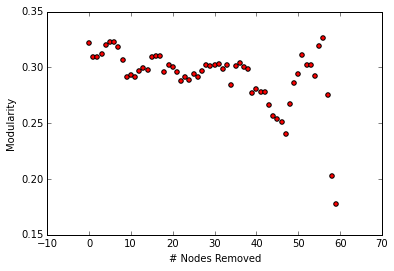

In [16]:
# Plot Modularities
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(range(len(m)), m, c = 'r')
#ax.scatter(range(len(mnull)), mnull, c = 'g')
plt.xlabel('# Nodes Removed')
plt.ylabel('Modularity')

Run Simulation with E4 Positive/Negative Subgroups
===========================
Use group level PiB network to simulat lesioning

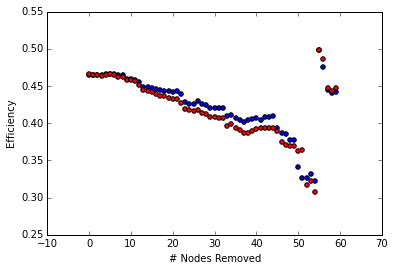

In [18]:
# Modify the PiB Correlation Matrix in order to be able to use nx.shortest_path_length
invpibmat = -1.0 * pibmat + 1.0
invpibnet = nx.from_numpy_matrix(invpibmat)
inp_fnet_neg, inp_fnet_pos, inp_pnet = fnet_neg.copy(), fnet_pos.copy(), invpibnet.copy()

# Run Simulation
#mpos, epos = run_simulation(inp_fnet_pos, inp_pnet, seed, 60)
#mneg, eneg = run_simulation(inp_fnet_neg, inp_pnet, seed, 60) 

mcopy = np.array(mpos)
np.save('/home/jagust/dino/surf/simulation_trials/subgroup_func_group_pib/e4_positive_modularity.npy', mcopy)
ecopy = np.array(epos)
np.save('/home/jagust/dino/surf/simulation_trials/subgroup_func_group_pib/e4_positive_efficiency.npy', ecopy)

mcopy = np.array(mneg)
np.save('/home/jagust/dino/surf/simulation_trials/subgroup_func_group_pib/e4_negative_modularity.npy', mcopy)
ecopy = np.array(eneg)
np.save('/home/jagust/dino/surf/simulation_trials/subgroup_func_group_pib/e4_negative_efficiency.npy', ecopy)

# Plot Efficiencies
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(range(len(epos)), epos, c = 'b')
ax.scatter(range(len(eneg)), eneg, c = 'r')
#ax.scatter(range(len(enull)), enull, c = 'g')

plt.xlabel('# Nodes Removed')
plt.ylabel('Efficiency')

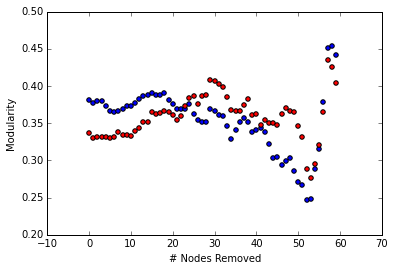

In [19]:
# Plot Modularities
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(range(len(mpos)), mpos, c = 'b')
ax.scatter(range(len(mneg)), mneg, c = 'r')
#ax.scatter(range(len(mnull)), mnull, c = 'g')

plt.xlabel('# Nodes Removed')
plt.ylabel('Modularity')

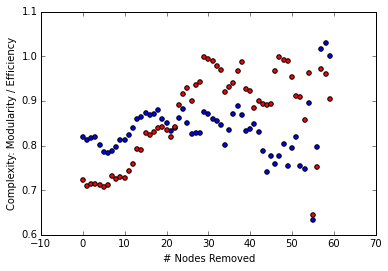

In [20]:
# Complexity = Modularity / Efficiency
comp_pos, comp_neg, comp_null = [], [], []

for i in range(len(mpos)):
    comp_pos.append(mpos[i] / epos[i])
    comp_neg.append(mneg[i] / eneg[i])
    #comp_null.append(mnull[i] / enull[i])

# Plot Integrations
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(range(len(comp_pos)), comp_pos, c = 'b')
ax.scatter(range(len(comp_neg)), comp_neg, c = 'r')
#ax.scatter(range(len(comp_null)), comp_null, c = 'g')

plt.xlabel('# Nodes Removed')
plt.ylabel('Complexity: Modularity / Efficiency')

Run Simulation with E4 Positive/Negative Subgroups
===========================
Use seperate subgrouplevel PiB networks to simulate lesioning

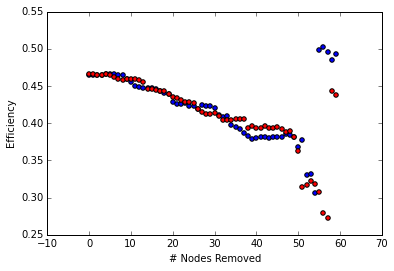

In [145]:
# Modify the PiB Correlation Matrix in order to be able to use nx.shortest_path_length
invpibmatpos = -1.0 * pibmatpos + 1.0
invpibnetpos = nx.from_numpy_matrix(invpibmatpos)

invpibmatneg = -1.0 * pibmatneg + 1.0
invpibnetneg = nx.from_numpy_matrix(invpibmatneg)

inp_fnet_neg, inp_fnet_pos, inp_pnet_pos, inp_pnet_neg = fnet_neg.copy(), fnet_pos.copy(), invpibnetpos.copy(), invpibnetneg.copy()

# Run Simulation
mpos, epos = run_simulation(inp_fnet_pos, inp_pnet_pos, seed, 60)
mneg, eneg = run_simulation(inp_fnet_neg, inp_pnet_neg, seed, 60) 

# Save results
mcopy = np.array(mpos)
np.save('/home/jagust/dino/surf/simulation_trials/subgroup_func_subgroup_pib/e4_positive_modularity.npy', mcopy)
ecopy = np.array(epos)
np.save('/home/jagust/dino/surf/simulation_trials/subgroup_func_subgroup_pib/e4_positive_efficiency.npy', ecopy)

mcopy = np.array(mneg)
np.save('/home/jagust/dino/surf/simulation_trials/subgroup_func_subgroup_pib/e4_negative_modularity.npy', mcopy)
ecopy = np.array(eneg)
np.save('/home/jagust/dino/surf/simulation_trials/subgroup_func_subgroup_pib/e4_negative_efficiency.npy', ecopy)

# Plot Efficiencies
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(range(len(epos)), epos, c = 'b')
ax.scatter(range(len(eneg)), eneg, c = 'r')

plt.ylabel('Efficiency')
plt.xlabel('# Nodes Removed')

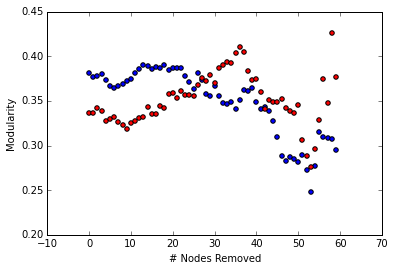

In [146]:
# Plot Modularity

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(range(len(mpos)), mpos, c = 'b')
ax.scatter(range(len(mneg)), mneg, c = 'r')

plt.ylabel('Modularity')
plt.xlabel('# Nodes Removed')

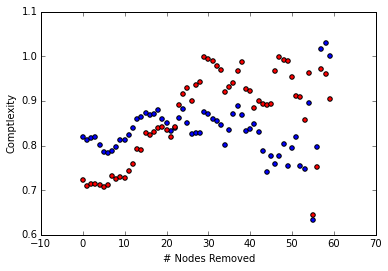

In [257]:
# Complexity = Modularity / Efficiency
integ_pos, integ_neg = [], []

for i in range(len(mpos)):
    integ_pos.append(mpos[i] / epos[i])
    integ_neg.append(mneg[i] / eneg[i])

# Plot Integrations
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(range(len(integ_pos)), integ_pos, c = 'b')
ax.scatter(range(len(integ_neg)), integ_neg, c = 'r')

plt.xlabel('# Nodes Removed')
plt.ylabel('Comptlexity')

~ 30 June 2015 ~

Run Simulation on Individual Subject Networks
========================
Might take a while

In [21]:
# Importing PiB Subject x Roi Data
pib_path = "/home/jagust/dino/graph/data/spreadsheets/pib/pib_summary_April2015.csv"
pib_dat = np.genfromtxt(pib_path, dtype = None)
pib_df = pd.DataFrame(pib_dat[1:], columns = pib_dat[0,:])
pib_df

,SUBID,scanner,ALL,Left-Amygdala,Left-Caudate,Left-Cerebellum-Cortex,Left-Hippocampus,Left-Pallidum,Left-Putamen,Left-Thalamus-Proper,...,ctx-rh-precentral,ctx-rh-precuneus,ctx-rh-rostralanteriorcingulate,ctx-rh-rostralmiddlefrontal,ctx-rh-superiorfrontal,ctx-rh-superiorparietal,ctx-rh-superiortemporal,ctx-rh-supramarginal,ctx-rh-temporalpole,ctx-rh-transversetemporal
0,B05-201_v1,ecat,1.273208,1.086826,1.30695,0.914772,1.10575,1.485336,1.520339,1.438444,...,1.261181,1.678135,1.815939,1.585188,1.449524,1.305483,1.19165,1.427792,0.971381,1.427594
1,B05-201_v2,ecat,1.529529,1.262077,1.471517,1.007894,1.250078,1.762007,1.84082,1.644838,...,1.527978,1.896365,1.982312,1.949927,1.694613,1.550804,1.546884,1.80008,1.180847,1.722326
2,B05-202_v1,ecat,1.007444,0.996752,1.009585,0.925908,1.059822,1.432898,1.297446,1.411028,...,1.032836,1.068713,1.126808,0.943386,1.051736,1.005358,0.990789,1.001359,0.866243,1.216935
3,B05-215_v1,ecat,1.30598,1.127267,1.381074,0.942477,1.12963,1.582226,1.656856,1.536823,...,1.236287,1.516453,1.65888,1.654284,1.547849,1.320834,1.278834,1.478342,0.979637,1.422982
4,B05-215_v2,ecat,1.264717,1.147965,1.253538,0.95681,1.092281,1.621212,1.61515,1.485623,...,1.230727,1.265551,1.608417,1.601515,1.397909,1.113494,1.333598,1.406201,1.047203,1.470536
5,B05-216_v1,ecat,0.995555,1.023762,1.157034,0.94195,1.049361,1.231373,1.263895,1.337227,...,1.074021,1.043423,0.866399,0.91353,0.977341,1.025745,0.953268,1.010699,0.778639,0.98168
6,B05-216_v2,ecat,0.997904,1.150004,1.202634,0.945866,1.13584,1.311408,1.310684,1.524631,...,1.036295,0.997476,1.002954,0.933247,0.936901,1.003824,0.96584,0.927819,0.932658,0.983451
7,B05-217_v1,ecat,0.969352,1.028224,0.942836,0.936708,1.043872,1.284137,1.225581,1.307024,...,1.044124,0.999279,0.960506,0.883778,0.939117,0.955872,0.911645,0.93609,0.769666,1.090629
8,B05-217_v2,ecat,0.991589,0.989056,0.947241,1.051914,1.006267,1.297097,1.218044,1.368012,...,1.059234,0.992348,0.996284,0.911932,0.980789,0.997719,0.911317,0.95865,0.821811,1.095473
9,B05-229_v1,ecat,0.9856,0.983856,0.839358,0.882943,1.037109,1.137595,1.157793,0.999583,...,1.021045,1.107521,0.883888,0.968344,0.960292,1.004711,0.942215,0.917178,0.829615,1.04856


In [23]:
# Load Matrices
globstr = "/home/jagust/graph/data/mri1.5/analysis/roi_networks/desikan/adjmat_gsr/*"
mat_paths = sorted(glob(globstr))
#mat_paths

In [36]:
def get_subsess(path):
    direc = "/home/jagust/graph/data/mri1.5/analysis/roi_networks/desikan/adjmat_gsr/"
    ind1 = len(direc)
    ind2 = ind1 + 18
    return path[ind1:ind2]
def is_geno_pos(ss):
    if len(ss) > 7:
        num_copies = subject_summary[subject_summary.Subsess == ss].values[0][6]
        if num_copies not in [0, 1, 2]:
            print "No genotype data: " + find_id(ss)
            return'x'
        else:
            return num_copies > 0.0
    else:
        num_copies = subject_summary[subject_summary.LBLID == ss].values[0][6]
        if num_copies not in [0, 1, 2]:
            print "No genotype data: " + find_id(ss)
            return
        else:
            return num_copies > 0.0

In [28]:
master_subject_path = "/home/jagust/dino/graph/data/mri1.5/rest/master_subject_summary.xlsx"
subject_summary = pd.ExcelFile(master_subject_path).parse("Sheet1")
subject_summary

,Subsess,LBLID,Birthday,Age,Gender,Edu,E4_Copies,MRI_Magnet,MRI_TR,MRI_Timepoints,MRI_directory,MRI_arda_dir,MRI_date,PIB_bacs_dir,PIB_bacs_date,FDG_bacs_dir,FDG_bacs_date,Cog_dir,Cog_date
0,B05-201_2009-03-27,B05-201,1933-07-14,75,F,20,1,1.5T,1.89,250,/home/jagust/graph/data/mri1.5/rest/B05-201_20...,/home/jagust/arda/lblid/B05-201/MRI_1.5_2009-0...,2009-03-27,/home/jagust/bacs_pet/PIB/old/ecat/B05-201_v1/pib,2009-03-23,/home/jagust/bacs_pet/FDG/old/ecat/B05-201_v1/fdg,2009-03-23,/home/jagust/arda/lblid/B05-201/COG_S2_2009-08...,2009-08-24
1,B05-201_2013-09-17,B05-201,1933-07-14,80,F,20,1,1.5T,2.20,185,/home/jagust/graph/data/mri1.5/rest/B05-201_20...,/home/jagust/arda/lblid/B05-201/MRI3_1.5_2013-...,2013-09-17,/home/jagust/bacs_pet/PIB/old/ecat/B05-201_v2/pib,2013-11-06,/home/jagust/bacs_pet/FDG/old/ecat/B05-201_v2/fdg,2013-11-06,/home/jagust/arda/lblid/B05-201/COG_S4_2013-06...,2013-06-26
2,B05-202_2009-06-09,B05-202,1928-07-28,80,F,17,0,1.5T,1.89,250,/home/jagust/graph/data/mri1.5/rest/B05-202_20...,/home/jagust/arda/lblid/B05-202/MRI_1.5_2009-0...,2009-06-09,/home/jagust/bacs_pet/PIB/old/ecat/B05-202_v1/pib,2009-06-02,/home/jagust/bacs_pet/FDG/old/ecat/B05-202_v1/fdg,2009-06-02,/home/jagust/arda/lblid/B05-202/COG_S2_2009-07...,2009-07-15
3,B05-202_2012-11-16,B05-202,1928-07-28,84,F,17,0,1.5T,2.20,185,/home/jagust/graph/data/mri1.5/rest/B05-202_20...,/home/jagust/arda/lblid/B05-202/MRI2_1.5_2012-...,2012-11-16,/home/jagust/bacs_pet/PIB/old/ecat/B05-202_v1/pib,2009-06-02,/home/jagust/bacs_pet/FDG/old/ecat/B05-202_v1/fdg,2009-06-02,/home/jagust/arda/lblid/B05-202/COG_S5_2012-09...,2012-09-12
4,B05-215_2008-10-01,B05-215,1938-06-21,70,F,20,2,1.5T,1.89,250,/home/jagust/graph/data/mri1.5/rest/B05-215_20...,/home/jagust/arda/lblid/B05-215/MRI_1.5_2008-1...,2008-10-01,/home/jagust/bacs_pet/PIB/old/ecat/B05-215_v1/pib,2008-10-06,/home/jagust/bacs_pet/FDG/old/ecat/B05-215_v1/fdg,2008-10-06,/home/jagust/arda/lblid/B05-215/COG_S3_2009-07...,2009-07-09
5,B05-215_2010-09-03,B05-215,1938-06-21,72,F,20,2,1.5T,2.20,185,/home/jagust/graph/data/mri1.5/rest/B05-215_20...,/home/jagust/arda/lblid/B05-215/MRI2_1.5_2010-...,2010-09-03,/home/jagust/bacs_pet/PIB/old/ecat/B05-215_v2/pib,2010-09-09,/home/jagust/bacs_pet/FDG/old/ecat/B05-215_v2/fdg,2010-09-14,/home/jagust/arda/lblid/B05-215/COG_S4_2011-07...,2011-07-26
6,B05-216_2008-10-07,B05-216,1941-09-01,67,F,18,0,1.5T,1.89,250,/home/jagust/graph/data/mri1.5/rest/B05-216_20...,/home/jagust/arda/lblid/B05-216/MRI_1.5_2008-1...,2008-10-07,/home/jagust/bacs_pet/PIB/old/ecat/B05-216_v1/pib,2008-11-20,/home/jagust/bacs_pet/FDG/old/ecat/B05-216_v1/fdg,2008-10-29,/home/jagust/arda/lblid/B05-216/COG_S3_2009-05...,2009-05-18
7,B05-216_2013-08-20,B05-216,1941-09-01,71,F,18,0,1.5T,2.20,185,/home/jagust/graph/data/mri1.5/rest/B05-216_20...,/home/jagust/arda/lblid/B05-216/MRI2_1.5_2013-...,2013-08-20,/home/jagust/bacs_pet/PIB/old/ecat/B05-216_v2/pib,2013-08-15,/home/jagust/bacs_pet/FDG/old/ecat/B05-216_v2/fdg,2013-08-15,/home/jagust/arda/lblid/B05-216/COG_S5_2013-06...,2013-06-07
8,B05-217_2009-03-16,B05-217,1937-10-10,71,M,18,0,1.5T,1.89,250,/home/jagust/graph/data/mri1.5/rest/B05-217_20...,/home/jagust/arda/lblid/B05-217/MRI_1.5_2009-0...,2009-03-16,/home/jagust/bacs_pet/PIB/old/ecat/B05-217_v1/pib,2009-03-18,/home/jagust/bacs_pet/FDG/old/ecat/B05-217_v1/fdg,2009-03-18,/home/jagust/arda/lblid/B05-217/COG_S3_2009-05...,2009-05-07
9,B05-217_2010-03-12,B05-217,1937-10-10,72,M,18,0,1.5T,2.20,185,/home/jagust/graph/data/mri1.5/rest/B05-217_20...,/home/jagust/arda/lblid/B05-217/MRI2_1.5_2010-...,2010-03-12,/home/jagust/bacs_pet/PIB/old/ecat/B05-217_v1/pib,2009-03-18,/home/jagust/bacs_pet/FDG/old/ecat/B05-217_v1/fdg,2009-03-18,/home/jagust/arda/lblid/B05-217/COG_S3_2009-05...,2009-05-07


Subject: 1 out of: 342
Subject: 2 out of: 342
Subject: 3 out of: 342
Subject: 4 out of: 342
Subject: 5 out of: 342
Subject: 6 out of: 342
Subject: 7 out of: 342
Subject: 8 out of: 342
Subject: 9 out of: 342
Subject: 10 out of: 342
Subject: 11 out of: 342
Subject: 12 out of: 342
Problem: /home/jagust/graph/data/mri1.5/analysis/roi_networks/desikan/adjmat_gsr/B05-218_2009-03-17_adjmat.npy
Subject: 13 out of: 342
Problem: /home/jagust/graph/data/mri1.5/analysis/roi_networks/desikan/adjmat_gsr/B05-229_2007-07-05_adjmat.npy
Subject: 14 out of: 342
Subject: 15 out of: 342
Subject: 16 out of: 342
Subject: 17 out of: 342
Subject: 18 out of: 342
Subject: 19 out of: 342
Subject: 20 out of: 342
Subject: 21 out of: 342
Subject: 22 out of: 342
Subject: 23 out of: 342
Subject: 24 out of: 342
Subject: 25 out of: 342
Subject: 26 out of: 342
Subject: 27 out of: 342
Problem: /home/jagust/graph/data/mri1.5/analysis/roi_networks/desikan/adjmat_gsr/B06-212_2009-04-20_adjmat.npy
Subject: 28 out of: 342
Subj

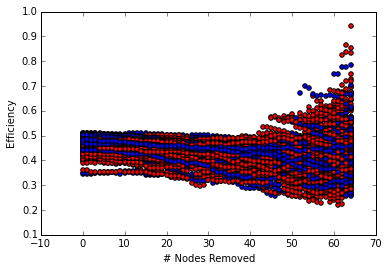

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
sub = 1
stop = 65
for p in mat_paths:
    try:
        print "Subject: " + str(sub) + " out of: " + str(len(mat_paths))
        sub += 1
        mat = np.load(p)
        thr_func_mat, c = util.threshold_adjacency_matrix(mat, cost = 0.20)
        ss = get_subsess(p)
        if type(is_geno_pos(ss)) == str:
            print "No geno data"
            continue
        elif is_geno_pos(ss):
            invpibmatpos = -1.0 * pibmatpos + 1.0
            invpibnetpos = nx.from_numpy_matrix(invpibmatpos)
            inp_pnet_pos = invpibnetpos.copy()

            # Run Simulation
            m, e = run_simulation(nx.Graph(thr_func_mat), inp_pnet_pos, seed, stop)
            mcopy = np.array(m)
            np.save('/home/jagust/dino/surf/simulation_trials/individuals/%s_modularity.npy' % (ss), mcopy)
            ecopy = np.array(e)
            np.save('/home/jagust/dino/surf/simulation_trials/individuals/%s_efficiency.npy' % (ss), ecopy)

            # Plot Efficiencies
            ax.scatter(range(len(e)), e, c = 'b')
        else:
            invpibmatneg = -1.0 * pibmatneg + 1.0
            invpibnetneg = nx.from_numpy_matrix(invpibmatneg)
            inp_pnet_neg = invpibnetneg.copy()

            # Run Simulation and save data
            m, e = run_simulation(nx.Graph(thr_func_mat), inp_pnet_neg, seed, stop) 
            mcopy = np.array(m)
            np.save('/home/jagust/dino/surf/simulation_trials/individuals/%s_modularity.npy' % (ss), mcopy)
            ecopy = np.array(e)
            np.save('/home/jagust/dino/surf/simulation_trials/individuals/%s_efficiency.npy' % (ss), ecopy)

            # Plot Efficiencies
            ax.scatter(range(len(e)), e, c = 'r')
    except:
        print "Problem: " + p

plt.ylabel('Efficiency')
plt.xlabel('# Nodes Removed')

~ 9 July 2015 ~

In [52]:
def find_id(s):
    inds = re.search('B[0,1,9]\d-\d\d\d', s)
    if inds is None:
        print 'Subject ID not found'
        return None
    else:
        inds = inds.span()
        return s[inds[0]: inds[1]]

In [56]:
globstr = '/home/jagust/dino/surf/simulation_trials/individuals/*_modularity.npy'
mod_paths = sorted(glob(globstr))

def create_points(checkpoint):
    x_vals_pos, y_vals_pos, x_vals_neg, y_vals_neg = [], [], [], []
    for p in mod_paths:
        mods = np.load(p)
        subid = find_id(p)
#         print p
#         print subid
        if is_geno_pos(subid):
            x_vals_pos.append(checkpoint)
            y_vals_pos.append(mods[checkpoint])
        elif not is_geno_pos(subid):
            x_vals_neg.append(checkpoint)
            y_vals_neg.append(mods[checkpoint])
    return x_vals_pos, y_vals_pos, x_vals_neg, y_vals_neg
        

In [82]:
xpos0, ypos0, xneg0, yneg0 = create_points(0)
xpos10, ypos10, xneg10, yneg10 = create_points(10)
xpos20, ypos20, xneg20, yneg20 = create_points(20)
xpos30, ypos30, xneg30, yneg30 = create_points(30)
xpos40, ypos40, xneg40, yneg40 = create_points(40)
xpos50, ypos50, xneg50, yneg50 = create_points(50)
xpos60, ypos60, xneg60, yneg60 = create_points(60)

print "E4 Negative Modularity Results"
print "# Nodes Removed : Mean , Std"
print "0 - Mean: " + str(np.mean(yneg0)) + " Std: " + str(np.std(yneg0))
print "10 - Mean: " + str(np.mean(yneg10)) + " Std: " + str(np.std(yneg10))
print "20 - Mean: " + str(np.mean(yneg20)) + " Std: " + str(np.std(yneg20))
print "30 - Mean: " + str(np.mean(yneg30)) + " Std: " + str(np.std(yneg30))
print "40 - Mean: " + str(np.mean(yneg40)) + " Std: " + str(np.std(yneg40))
print "50 - Mean: " + str(np.mean(yneg50)) + " Std: " + str(np.std(yneg50))
print "60 - Mean: " + str(np.mean(yneg60)) + " Std: " + str(np.std(yneg60))
print ""
print ""
print "E4 Positive Modularity Results"
print "# Nodes Removed : Mean , Std"
print "0 - Mean: " + str(np.mean(ypos0)) + " Std: " + str(np.std(ypos0))
print "10 - Mean: " + str(np.mean(ypos10)) + " Std: " + str(np.std(ypos10))
print "20 - Mean: " + str(np.mean(ypos20)) + " Std: " + str(np.std(ypos20))
print "30 - Mean: " + str(np.mean(ypos30)) + " Std: " + str(np.std(ypos30))
print "40 - Mean: " + str(np.mean(ypos40)) + " Std: " + str(np.std(ypos40))
print "50 - Mean: " + str(np.mean(ypos50)) + " Std: " + str(np.std(ypos50))
print "60 - Mean: " + str(np.mean(ypos60)) + " Std: " + str(np.std(ypos60))

E4 Negative Modularity Results
# Nodes Removed : Mean , Std
0 - Mean: 0.47333571102 Std: 0.0235139369331
10 - Mean: 0.465408772072 Std: 0.0242114781995
20 - Mean: 0.452840012692 Std: 0.027358421219
30 - Mean: 0.438633258589 Std: 0.0297206699019
40 - Mean: 0.424946756742 Std: 0.034237995777
50 - Mean: 0.402300269945 Std: 0.0517308802267
60 - Mean: 0.395345354618 Std: 0.0816913425874


E4 Positive Modularity Results
# Nodes Removed : Mean , Std
0 - Mean: 0.471160160583 Std: 0.032023094956
10 - Mean: 0.46489553845 Std: 0.0313930816747
20 - Mean: 0.451685111139 Std: 0.0350205611856
30 - Mean: 0.438782347379 Std: 0.0375999385072
40 - Mean: 0.419468409482 Std: 0.0421979380961
50 - Mean: 0.424242222713 Std: 0.0466678680496
60 - Mean: 0.419638971644 Std: 0.0843127105886


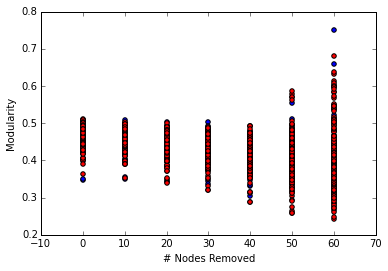

In [83]:
# Plot Modularities
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(xpos0, ypos0, c = 'b')
ax.scatter(xneg0, yneg0, c = 'r')


ax.scatter(xpos10, ypos10, c = 'b')
ax.scatter(xneg10, yneg10, c = 'r')

ax.scatter(xpos20, ypos20, c = 'b')
ax.scatter(xneg20, yneg20, c = 'r')

ax.scatter(xpos30, ypos30, c = 'b')
ax.scatter(xneg30, yneg30, c = 'r')

ax.scatter(xpos40, ypos40, c = 'b')
ax.scatter(xneg40, yneg40, c = 'r')


ax.scatter(xpos50, ypos50, c = 'b')
ax.scatter(xneg50, yneg50, c = 'r')

ax.scatter(xpos60, ypos60, c = 'b')
ax.scatter(xneg60, yneg60, c = 'r')

plt.xlabel('# Nodes Removed')
plt.ylabel('Modularity')

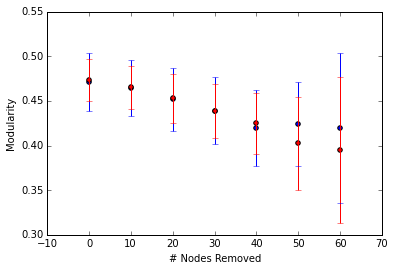

In [81]:
plt.figure()

plt.scatter(0, np.mean(ypos0), c = 'b')
plt.errorbar(0, np.mean(ypos0), yerr = np.std(ypos0), c = 'b')
plt.scatter(0, np.mean(yneg0), c = 'r')
plt.errorbar(0, np.mean(yneg0), yerr = np.std(yneg0), c = 'r')

plt.scatter(10, np.mean(ypos10), c = 'b')
plt.errorbar(10, np.mean(ypos10), yerr = np.std(ypos10), c = 'b')
plt.scatter(10, np.mean(yneg10), c = 'r')
plt.errorbar(10, np.mean(yneg10), yerr = np.std(yneg10), c = 'r')

plt.scatter(20, np.mean(ypos20), c = 'b')
plt.errorbar(20, np.mean(ypos20), yerr = np.std(ypos20), c = 'b')
plt.scatter(20, np.mean(yneg20), c = 'r')
plt.errorbar(20, np.mean(yneg20), yerr = np.std(yneg20), c = 'r')

plt.scatter(30, np.mean(ypos30), c = 'b')
plt.errorbar(30, np.mean(ypos30), yerr = np.std(ypos30), c = 'b')
plt.scatter(30, np.mean(yneg30), c = 'r')
plt.errorbar(30, np.mean(yneg30), yerr = np.std(yneg30), c = 'r')

plt.scatter(40, np.mean(ypos40), c = 'b')
plt.errorbar(40, np.mean(ypos40), yerr = np.std(ypos40), c = 'b')
plt.scatter(40, np.mean(yneg40), c = 'r')
plt.errorbar(40, np.mean(yneg40), yerr = np.std(yneg40), c = 'r')

plt.scatter(50, np.mean(ypos50), c = 'b')
plt.errorbar(50, np.mean(ypos50), yerr = np.std(ypos50), c = 'b')
plt.scatter(50, np.mean(yneg50), c = 'r')
plt.errorbar(50, np.mean(yneg50), yerr = np.std(yneg50), c = 'r')

plt.scatter(60, np.mean(ypos60), c = 'b')
plt.errorbar(60, np.mean(ypos60), yerr = np.std(ypos60), c = 'b')
plt.scatter(60, np.mean(yneg60), c = 'r')
plt.errorbar(60, np.mean(yneg60), yerr = np.std(yneg60), c = 'r')

plt.xlabel("# Nodes Removed")
plt.ylabel("Modularity")

In [64]:
globstr = '/home/jagust/dino/surf/simulation_trials/individuals/*_efficiency.npy'
eff_paths = sorted(glob(globstr))

def create_points_eff(checkpoint):
    x_vals_pos, y_vals_pos, x_vals_neg, y_vals_neg = [], [], [], []
    for p in eff_paths:
        mods = np.load(p)
        subid = find_id(p)
        if is_geno_pos(subid):
            x_vals_pos.append(checkpoint)
            y_vals_pos.append(mods[checkpoint])
        elif not is_geno_pos(subid):
            x_vals_neg.append(checkpoint)
            y_vals_neg.append(mods[checkpoint])
    return x_vals_pos, y_vals_pos, x_vals_neg, y_vals_neg
        

E4 Negative Efficiency Results
# Nodes Removed - Mean , Std
0 - Mean: 0.47333571102 Std: 0.0235139369331
10 - Mean: 0.465408772072 Std: 0.0242114781995
20 - Mean: 0.452840012692 Std: 0.027358421219
30 - Mean: 0.438633258589 Std: 0.0297206699019
40 - Mean: 0.424946756742 Std: 0.034237995777
50 - Mean: 0.402300269945 Std: 0.0517308802267
60 - Mean: 0.395345354618 Std: 0.0816913425874


E4 Positive Efficiency Results
# Nodes Removed : Mean , Std
0 - Mean: 0.471160160583 Std: 0.032023094956
10 - Mean: 0.46489553845 Std: 0.0313930816747
20 - Mean: 0.451685111139 Std: 0.0350205611856
30 - Mean: 0.438782347379 Std: 0.0375999385072
40 - Mean: 0.419468409482 Std: 0.0421979380961
50 - Mean: 0.424242222713 Std: 0.0466678680496
60 - Mean: 0.419638971644 Std: 0.0843127105886


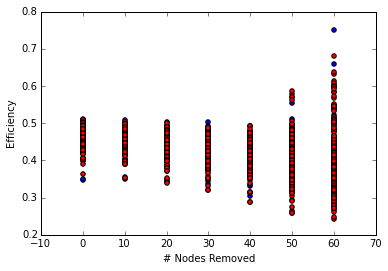

In [68]:
xpos0, ypos0, xneg0, yneg0 = create_points_eff(0)
xpos10, ypos10, xneg10, yneg10 = create_points_eff(10)
xpos20, ypos20, xneg20, yneg20 = create_points_eff(20)
xpos30, ypos30, xneg30, yneg30 = create_points_eff(30)
xpos40, ypos40, xneg40, yneg40 = create_points_eff(40)
xpos50, ypos50, xneg50, yneg50 = create_points_eff(50)
xpos60, ypos60, xneg60, yneg60 = create_points_eff(60)

print "E4 Negative Efficiency Results"
print "# Nodes Removed - Mean , Std"
print "0 - Mean: " + str(np.mean(yneg0)) + " Std: " + str(np.std(yneg0))
print "10 - Mean: " + str(np.mean(yneg10)) + " Std: " + str(np.std(yneg10))
print "20 - Mean: " + str(np.mean(yneg20)) + " Std: " + str(np.std(yneg20))
print "30 - Mean: " + str(np.mean(yneg30)) + " Std: " + str(np.std(yneg30))
print "40 - Mean: " + str(np.mean(yneg40)) + " Std: " + str(np.std(yneg40))
print "50 - Mean: " + str(np.mean(yneg50)) + " Std: " + str(np.std(yneg50))
print "60 - Mean: " + str(np.mean(yneg60)) + " Std: " + str(np.std(yneg60))
print ""
print ""
print "E4 Positive Efficiency Results"
print "# Nodes Removed : Mean , Std"
print "0 - Mean: " + str(np.mean(ypos0)) + " Std: " + str(np.std(ypos0))
print "10 - Mean: " + str(np.mean(ypos10)) + " Std: " + str(np.std(ypos10))
print "20 - Mean: " + str(np.mean(ypos20)) + " Std: " + str(np.std(ypos20))
print "30 - Mean: " + str(np.mean(ypos30)) + " Std: " + str(np.std(ypos30))
print "40 - Mean: " + str(np.mean(ypos40)) + " Std: " + str(np.std(ypos40))
print "50 - Mean: " + str(np.mean(ypos50)) + " Std: " + str(np.std(ypos50))
print "60 - Mean: " + str(np.mean(ypos60)) + " Std: " + str(np.std(ypos60))


# Plot
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(xpos0, ypos0, c = 'b')
ax.scatter(xneg0, yneg0, c = 'r')


ax.scatter(xpos10, ypos10, c = 'b')
ax.scatter(xneg10, yneg10, c = 'r')

ax.scatter(xpos20, ypos20, c = 'b')
ax.scatter(xneg20, yneg20, c = 'r')

ax.scatter(xpos30, ypos30, c = 'b')
ax.scatter(xneg30, yneg30, c = 'r')

ax.scatter(xpos40, ypos40, c = 'b')
ax.scatter(xneg40, yneg40, c = 'r')


ax.scatter(xpos50, ypos50, c = 'b')
ax.scatter(xneg50, yneg50, c = 'r')

ax.scatter(xpos60, ypos60, c = 'b')
ax.scatter(xneg60, yneg60, c = 'r')

plt.xlabel('# Nodes Removed')
plt.ylabel('Efficiency')

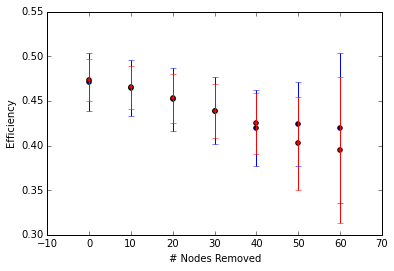

In [79]:
plt.figure()

plt.scatter(0, np.mean(ypos0), c = 'b')
plt.errorbar(0, np.mean(ypos0), yerr = np.std(ypos0), c = 'b')
plt.scatter(0, np.mean(yneg0), c = 'r')
plt.errorbar(0, np.mean(yneg0), yerr = np.std(yneg0), c = 'r')

plt.scatter(10, np.mean(ypos10), c = 'b')
plt.errorbar(10, np.mean(ypos10), yerr = np.std(ypos10), c = 'b')
plt.scatter(10, np.mean(yneg10), c = 'r')
plt.errorbar(10, np.mean(yneg10), yerr = np.std(yneg10), c = 'r')

plt.scatter(20, np.mean(ypos20), c = 'b')
plt.errorbar(20, np.mean(ypos20), yerr = np.std(ypos20), c = 'b')
plt.scatter(20, np.mean(yneg20), c = 'r')
plt.errorbar(20, np.mean(yneg20), yerr = np.std(yneg20), c = 'r')

plt.scatter(30, np.mean(ypos30), c = 'b')
plt.errorbar(30, np.mean(ypos30), yerr = np.std(ypos30), c = 'b')
plt.scatter(30, np.mean(yneg30), c = 'r')
plt.errorbar(30, np.mean(yneg30), yerr = np.std(yneg30), c = 'r')

plt.scatter(40, np.mean(ypos40), c = 'b')
plt.errorbar(40, np.mean(ypos40), yerr = np.std(ypos40), c = 'b')
plt.scatter(40, np.mean(yneg40), c = 'r')
plt.errorbar(40, np.mean(yneg40), yerr = np.std(yneg40), c = 'r')

plt.scatter(50, np.mean(ypos50), c = 'b')
plt.errorbar(50, np.mean(ypos50), yerr = np.std(ypos50), c = 'b')
plt.scatter(50, np.mean(yneg50), c = 'r')
plt.errorbar(50, np.mean(yneg50), yerr = np.std(yneg50), c = 'r')

plt.scatter(60, np.mean(ypos60), c = 'b')
plt.errorbar(60, np.mean(ypos60), yerr = np.std(ypos60), c = 'b')
plt.scatter(60, np.mean(yneg60), c = 'r')
plt.errorbar(60, np.mean(yneg60), yerr = np.std(yneg60), c = 'r')

plt.xlabel("# Nodes Removed")
plt.ylabel("Efficiency")

~ 1 July 2015 ~

In [29]:
def run_simulation_rc(fnet, pnet, seed, stop):
    ''' Run lesion simulation
    Parameters
    ----------
    fnet : functional network
    pnet : PiB correlation network
    seed : beginning of simulated lesioning
    stop : terminate simulation after removing stop number of nodes
    
    Returns
    -------
    five : tracks rich-club coefficient at k = 5
    ten : tracks rich-club coefficient at k = 10
    fifteen : tracks rich-club coefficient at k = 15
    twenty : tracks rich-club coefficient at k = 20
    twenty_five : tracks rich-club coefficient at k = 25

    Notes:
    '''
    # Initial global metrics
    five, ten, fifteen, twenty, twenty_five = [], [], [], [], []
    rc = nx.rich_club_coefficient(fnet).values()
    five.append(rc[4])
    ten.append(rc[9])
    fifteen.append(rc[14])
    twenty.append(rc[19])
    twenty_five.append(rc[24])
    
    
    removed = {seed}
    while len(removed) < stop: #len(fnet.nodes()):
        rem = find_next_node(removed, pnet)
        removed.add(rem)
        fnet.remove_edges_from(fnet.edges(rem))
        
        rc = nx.rich_club_coefficient(fnet).values()
        if len(rc)>4:
            five.append(rc[4])
        if len(rc)>9:
            ten.append(rc[9])
        if len(rc)>14:    
            fifteen.append(rc[14])
        if len(rc)>20:    
            twenty.append(rc[19])
        if len(rc)>24:    
            twenty_five.append(rc[24])
    
    return five, ten, fifteen, twenty, twenty_five

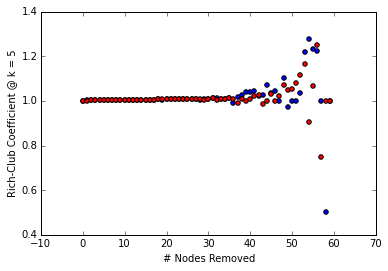

In [30]:
# Modify the PiB Correlation Matrix in order to be able to use nx.shortest_path_length
invpibmat = -1.0 * pibmat + 1.0
invpibnet = nx.from_numpy_matrix(invpibmat)
inp_fnet_neg, inp_fnet_pos, inp_pnet = fnet_neg.copy(), fnet_pos.copy(), invpibnet.copy()

# Run Simulation
fivep, tenp, fifteenp, twentyp, twenty_fivep = run_simulation_rc(inp_fnet_pos, inp_pnet, seed, 60)
fiven, tenn, fifteenn, twentyn, twenty_fiven = run_simulation_rc(inp_fnet_neg, inp_pnet, seed, 60)

# Plot Rich Club Values
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(range(len(fivep)), fivep, c = 'b')
ax.scatter(range(len(fiven)), fiven, c = 'r')
#ax.scatter(range(len(enull)), enull, c = 'g')

plt.xlabel('# Nodes Removed')
plt.ylabel('Rich-Club Coefficient @ k = 5')

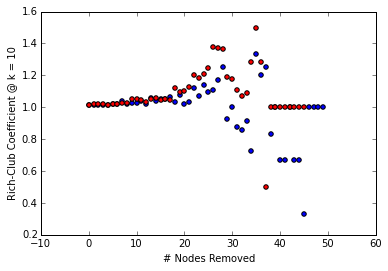

In [31]:
# Plot Rich Club Values
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(range(len(tenp)), tenp, c = 'b')
ax.scatter(range(len(tenn)), tenn, c = 'r')

plt.xlabel('# Nodes Removed')
plt.ylabel('Rich-Club Coefficient @ k = 10')

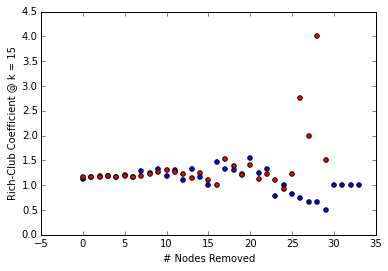

In [32]:
# Plot Rich Club Values
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(range(len(fifteenp)), fifteenp, c = 'b')
ax.scatter(range(len(fifteenn)), fifteenn, c = 'r')

plt.xlabel('# Nodes Removed')
plt.ylabel('Rich-Club Coefficient @ k = 15')

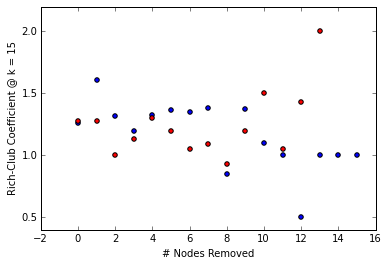

In [33]:
# Plot Rich Club Values
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(range(len(twentyp)), twentyp, c = 'b')
ax.scatter(range(len(twentyn)), twentyn, c = 'r')

plt.xlabel('# Nodes Removed')
plt.ylabel('Rich-Club Coefficient @ k = 15')

In [ ]:
# Think about what were going to do for modularity (i.e., should partititons change as 

~ 2 July 2015 ~

Testing Written Functions
==========

In [29]:
toy = nx.Graph()

In [30]:
toy.add_edges_from([(1, 2, {'weight' : 0.1}), (1, 3, {'weight' : 0.2}), (2, 4, {'weight' : .2}), (3, 4, {'weight' : .3})]) 

In [31]:
toy.add_edge(1, 4, {'weight' : 0.05})
toy.add_edge(1, 5, {'weight' : 0.01})
toy.add_edge(5, 4, {'weight' : 0.02})
r = {4, 5}
n = find_next_node(r, toy)
n

1

In [32]:
toy.edges(data=True)

[(1, 2, {'weight': 0.1}),
 (1, 3, {'weight': 0.2}),
 (1, 4, {'weight': 0.05}),
 (1, 5, {'weight': 0.01}),
 (2, 4, {'weight': 0.2}),
 (3, 4, {'weight': 0.3}),
 (4, 5, {'weight': 0.02})]

In [41]:
toy.add_edge(1, 6, {'weight' : -0.5})
remove_neg_weight_edges(toy)
toy.edges(data=True)

[(1, 2, {'weight': 0.1}),
 (1, 3, {'weight': 0.2}),
 (1, 4, {'weight': 0.05}),
 (1, 5, {'weight': 0.01}),
 (1, 6, {'weight': -0.5}),
 (2, 4, {'weight': 0.2}),
 (3, 4, {'weight': 0.3}),
 (4, 5, {'weight': 0.02})]

In [74]:
toy.nodes()

[1, 2, 3, 4, 5]

In [48]:
remove_neg_weight_edges(toy)
toy.edges(data=True)

[(1, 2, {'weight': 0.1}),
 (1, 3, {'weight': 0.2}),
 (1, 4, {'weight': 0.05}),
 (1, 5, {'weight': 0.01}),
 (2, 4, {'weight': 0.2}),
 (3, 4, {'weight': 0.3}),
 (4, 5, {'weight': 0.02})]

In [214]:
mat = btc.randomizer_bin_und(thr_func_mat, .99)

In [215]:
g = nx.Graph(mat)
len(g.edges(data=True))

670

In [208]:
thr_func_mat

array([[False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False,  True, False, ..., False, False, False],
       [False,  True, False, ..., False, False,  True],
       [False, False, False, ..., False,  True, False]], dtype=bool)

In [209]:
g = nx.from_numpy_matrix(thr_func_mat)
len(g.edges(data=True))

632

In [237]:
def rand_graph(g):
    mat = nx.to_numpy_matrix(g)
    return btc.randomizer_bin_und(np.array(mat), 0.99)

In [238]:
g = rand_graph(nx.Graph(thr_func_mat))

(array([  1.,   1.,   2.,  13.,   5.,   9.,  14.,  19.,   6.,  10.]),
 array([  3. ,   5.2,   7.4,   9.6,  11.8,  14. ,  16.2,  18.4,  20.6,
         22.8,  25. ]),
 <a list of 10 Patch objects>)

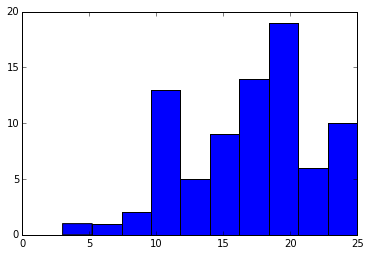

In [239]:
plt.hist(nx.Graph(g).degree().values())

(array([  2.,   0.,  10.,   8.,   4.,  12.,  22.,   7.,   9.,   6.]),
 array([  3. ,   5.2,   7.4,   9.6,  11.8,  14. ,  16.2,  18.4,  20.6,
         22.8,  25. ]),
 <a list of 10 Patch objects>)

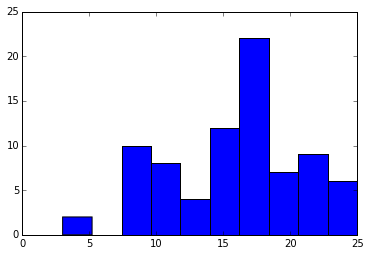

In [240]:
plt.hist(nx.Graph(thr_func_mat).degree().values())